# **Proyecto Reconocimiento de Emociones Faciales con VGG16**
**Autor:**
+ Aracelli Rivas Tapia

**Correo Electrónico:**
+ aracelli.rivas2101@alumnos.ubiobio.cl

El reconocimiento de emociones faciales es un desafío importante en el campo de Deep Learning debido a sus múltiples aplicaciones en áreas como la psicología, la educación, la seguridad y las interfaces humano-computadora. Este proyecto tiene como objetivo desarrollar un modelo capaz de identificar emociones básicas (neutral, triste, feliz, enojo) utilizando imágenes faciales.

La motivación principal de este trabajo es explorar arquitecturas preentrenadas, la cual en este caso es VGG16. Además, se busca validar el modelo con imágenes tomadas en condiciones reales, demostrando su aplicabilidad práctica.

### Importación de Librerías

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalMaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

2024-12-20 20:15:34.076982: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 20:15:34.228679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734736534.288272     567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734736534.306459     567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 20:15:34.438103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Descargar Dataset

In [ ]:
!kaggle datasets download -d noamsegal/affectnet-training-data

Dataset URL: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
 99% 311M/314M [00:02<00:00, 137MB/s]
100% 314M/314M [00:02<00:00, 113MB/s]


In [ ]:
!unzip affectnet-training-data.zip -d affectnet

Streaming output truncated to the last 5000 lines.
  inflating: affectnet/sad/image0025659.jpg  
  inflating: affectnet/sad/image0025666.jpg  
  inflating: affectnet/sad/image0025673.jpg  
  inflating: affectnet/sad/image0025679.jpg  
  inflating: affectnet/sad/image0025681.jpg  
  inflating: affectnet/sad/image0025693.jpg  
  inflating: affectnet/sad/image0025694.jpg  
  inflating: affectnet/sad/image0025697.jpg  
  inflating: affectnet/sad/image0025715.jpg  
  inflating: affectnet/sad/image0025725.jpg  
  inflating: affectnet/sad/image0025726.jpg  
  inflating: affectnet/sad/image0025730.jpg  
  inflating: affectnet/sad/image0025736.jpg  
  inflating: affectnet/sad/image0025753.jpg  
  inflating: affectnet/sad/image0025760.jpg  
  inflating: affectnet/sad/image0025761.jpg  
  inflating: affectnet/sad/image0025769.jpg  
  inflating: affectnet/sad/image0025774.jpg  
  inflating: affectnet/sad/image0025787.jpg  
  inflating: affectnet/sad/image0025808.jpg  
  inflating: affectnet/sad/im

### Distribución de los Datos

In [2]:
from collections import Counter

Utilicé Counter, el cual es un diccionario que cuenta el número de imágenes en cada categoría.

In [3]:
data = os.path.abspath('affectnet')

In [4]:
print(data)

/home/rou/affectnet


In [5]:
def categoria_images(data):
    if not os.path.exists(data):
        raise ValueError(f"La ruta {data} no existe.")

    categorias = os.listdir(data) # lista categorías
    image_count = Counter() # contador de imágenes

    for categoria in categorias:
        category_path = os.path.join(data, categoria)
        if os.path.isdir(category_path):
            image_count[categoria] = len([
                f for f in os.listdir(category_path)
                if os.path.isfile(os.path.join(category_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])

    return image_count

In [6]:
image_counts = categoria_images(data)
print(image_counts)

Counter({'neutral': 2000, 'disgust': 2000, 'contempt': 2000, 'fear': 2000, 'anger': 2000, 'sad': 2000, 'surprise': 2000, 'happy': 2000})


Como se puede observar, las clases estaban desbalanceadas, siendo la mayor neutral con 5126 imagenes y la menor disgusto con 2477 imagenes.

### Balance de Imagenes

Realicé un balance de imagenes, para que así cada categoría tuviera 2000 imagenes.

In [7]:
import random

In [8]:
def balance_dataset_simple(data, target_count=2000):

    for category in os.listdir(data):
        category_path = os.path.join(data, category)

        if os.path.isdir(category_path):
            image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if len(image_files) > target_count:
                images_to_remove = random.sample(image_files, len(image_files) - target_count)

                for img in images_to_remove:
                    os.remove(os.path.join(category_path, img))

                print(f"Categoría '{category}' reducida a {target_count} imágenes.")
            else:
                print(f"Categoría '{category}' ya tiene {len(image_files)} imágenes o menos. No se necesita reducción.")

data = '/home/rou/affectnet'

balance_dataset_simple(data, target_count=2000)

Categoría 'neutral' ya tiene 2000 imágenes o menos. No se necesita reducción.
Categoría 'disgust' ya tiene 2000 imágenes o menos. No se necesita reducción.
Categoría 'contempt' ya tiene 2000 imágenes o menos. No se necesita reducción.
Categoría 'fear' ya tiene 2000 imágenes o menos. No se necesita reducción.
Categoría 'anger' ya tiene 2000 imágenes o menos. No se necesita reducción.
Categoría 'sad' ya tiene 2000 imágenes o menos. No se necesita reducción.
Categoría 'surprise' ya tiene 2000 imágenes o menos. No se necesita reducción.
Categoría 'happy' ya tiene 2000 imágenes o menos. No se necesita reducción.


### Filtrado de Emociones

En un inicio, resultó complicado trabajar con las 8 categorías de emociones disponibles en el dataset, ya que algunas emociones tenían características visuales muy similares, lo que aumentaba la confusión del modelo. Por ello, centrarme en 4 emociones principales (triste, feliz, enojo y neutral), las cuales son más representativas.

In [17]:
import shutil

In [18]:
data = "/home/rou/emociones"

In [ ]:
def filtrar_emociones(data_dir, emociones_requeridas, destino):
    if not os.path.exists(destino):
        os.makedirs(destino)
    for emocion in emociones_requeridas:
        emocion_origen = os.path.join(data_dir, emocion)
        emocion_destino = os.path.join(destino, emocion)
        if os.path.exists(emocion_origen):
            shutil.copytree(emocion_origen, emocion_destino)

data_dir = "/home/rou/affectnet"
emociones_requeridas = ['neutral', 'sad', 'happy', 'anger']
destino = "/home/rou/emociones"
filtrar_emociones(data_dir, emociones_requeridas, destino)

Esta función filtra las emociones requeridas y las copia a un nuevo directorio.

### Entrenamiento y construccion del Modelo

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

**rescale=1./255**
Normaliza los valores de los píxeles de las imágenes, que originalmente están en el rango de 0 a 255, a un rango de 0 a 1. Ayuda a que el modelo converja más rápido y de manera más estable, ya que los valores en un rango pequeño mejoran la eficiencia del entrenamiento.

**rotation_range=20**
Aplica una rotación aleatoria de hasta 20 grados a las imágenes. Aumenta la variabilidad en los datos y hace que el modelo sea más robusto ante imágenes con diferentes ángulos.

**width_shift_range=0.2 y height_shift_range=0.2**
Desplaza la imagen horizontalmente (width_shift) y verticalmente (height_shift) hasta un 20% del tamaño de la imagen. Simula ligeros desplazamientos que ocurren en imágenes reales, ayudando al modelo a ser menos sensible a la posición del objeto en la imagen.

**shear_range=0.2** Aplica un efecto de cizallamiento (shear) a las imágenes, distorsionándolas ligeramente en forma trapezoidal. Aumenta la capacidad del modelo para generalizar cuando las imágenes tienen pequeñas deformaciones o perspectivas diferentes.

**zoom_range=0.2**
Realiza un zoom aleatorio en las imágenes hasta un 20%. Ayuda al modelo a manejar variaciones en la escala de los objetos dentro de las imágenes.

**horizontal_flip=True**
Invierte las imágenes horizontalmente de manera aleatoria. Es útil en imágenes de rostros y objetos que no tienen una orientación fija, ayudando al modelo a ser robusto ante imágenes simétricas.

**validation_split=0.2**
Divide los datos en entrenamiento (80%) y validación (20%). Permite evaluar el rendimiento del modelo en un subconjunto de datos que no ha visto durante el entrenamiento, ayudando a detectar problemas como sobreajuste.

**El uso de estos parámetros tiene como objetivo aumentar artificialmente el tamaño del dataset a través de data augmentation. Esto mejora la capacidad de generalización del modelo, evitando que se sobreajuste y asegurando un mejor desempeño en imágenes del mundo real.**

In [22]:
train_generator = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 6400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


El target_size es de máximo 224x224 pixeles, ya que el modelo VGG16 es su tamaño estándar para el que fue entrenado.

In [23]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

In [24]:
x = GlobalMaxPooling2D()(last_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(emociones_requeridas), activation='softmax')(x)

Aquí se agregan capas personalizadas al modelo base VGG16. Primero, GlobalMaxPooling2D reduce la salida de la última capa convolucional a una representación compacta, seleccionando el valor máximo por canal. Luego, se añaden capas densas con 256 y 128 neuronas, cada una con activación 'relu' para capturar patrones más complejos. Se incluyen Dropout (0.4 y 0.3) para evitar el sobreajuste al desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento. Finalmente, la capa Dense con activación softmax produce la salida con probabilidades para las clases correspondientes a las emociones.

In [25]:
model = Model(inputs=base_model.input, outputs=output)

In [26]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
images, _ = next(train_generator)
images[0].shape

(224, 224, 3)

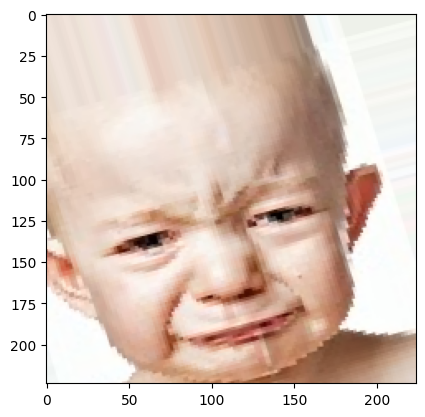

In [ ]:
images, _ = next(train_generator)
plt.imshow(images[0])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,879,428 (56.76 MB)

 Trainable params: 14,879,428 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

Utilicé EarlyStopping, ya que detiene el entrenamiento automáticamente cuando el modelo deja de mejorar

In [29]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[early_stopping]
)

/home/rou/IA/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1734736625.087218     667 service.cc:148] XLA service 0x7fbe74002680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734736625.087455     667 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-20 20:17:05.146307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734736625.439347     667 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734736659.548324     667 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2697 - loss: 1.5281

2024-12-20 20:18:49.882680: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 433ms/step - accuracy: 0.2698 - loss: 1.5276 - val_accuracy: 0.4187 - val_loss: 1.1723
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 364ms/step - accuracy: 0.4106 - loss: 1.1856 - val_accuracy: 0.5425 - val_loss: 0.9388
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 366ms/step - accuracy: 0.4835 - loss: 1.0055 - val_accuracy: 0.6544 - val_loss: 0.7368
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 354ms/step - accuracy: 0.6042 - loss: 0.8108 - val_accuracy: 0.6881 - val_loss: 0.6092
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 337ms/step - accuracy: 0.6661 - loss: 0.7006 - val_accuracy: 0.6975 - val_loss: 0.6027
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 340ms/step - accuracy: 0.6837 - loss: 0.6558 - val_accuracy: 0.7500 - val_loss: 0.5235
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 340ms/step - accuracy: 0.6969 - loss: 0.6138 - val_accuracy: 0.7487 - val_loss: 0.5050
Epoch 8/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 339ms/step - accuracy: 0.7151 - loss: 0.5902 - va

In [30]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Pérdida: {loss}, Precisión: {accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8432 - loss: 0.3624
Pérdida: 0.35026368498802185, Precisión: 0.8556249737739563


In [31]:
for layer in base_model.layers[-4:]:  # descongela las últimas 4 capas
    layer.trainable = True

Para realizar fine-tuning descongele las ultimas 4 capas

In [32]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[early_stopping]
)

Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 72s 343ms/step - accuracy: 0.8802 - loss: 0.3175 - val_accuracy: 0.8456 - val_loss: 0.3749
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 341ms/step - accuracy: 0.8676 - loss: 0.3335 - val_accuracy: 0.8631 - val_loss: 0.3302
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 348ms/step - accuracy: 0.8775 - loss: 0.3161 - val_accuracy: 0.8556 - val_loss: 0.3678
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 338ms/step - accuracy: 0.8764 - loss: 0.3178 - val_accuracy: 0.8625 - val_loss: 0.3467
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 342ms/step - accuracy: 0.8857 - loss: 0.2965 - val_accuracy: 0.8419 - val_loss: 0.3755
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 341ms/step - accuracy: 0.9012 - loss: 0.2743 - val_accuracy: 0.8363 - val_loss: 0.4209
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 344ms/step - accuracy: 0.8936 - loss: 0.2634 - val_accuracy: 0.8500 - val_loss: 0.3929


In [34]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Pérdida: {loss}, Precisión: {accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8370 - loss: 0.3816
Pérdida: 0.3443014621734619, Precisión: 0.8556249737739563


### Visualizacion Resultados

In [35]:
y_pred = np.argmax(model.predict(validation_generator), axis=1)
y_true = validation_generator.classes
conf_matrix = confusion_matrix(y_true, y_pred)

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step


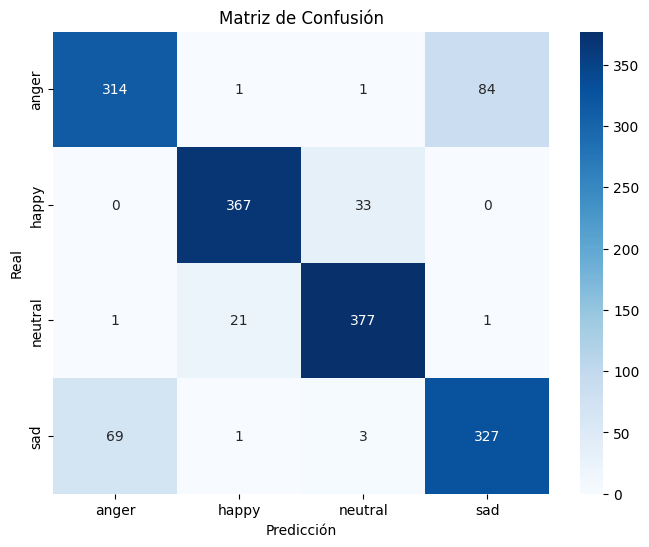

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

En mi matriz de confusión, observé que "Neutral" fue la clase mejor clasificada con 377 aciertos, mientras que "Anger" tuvo 314, aunque se confundió 84 veces con "Sad". "Happy" logró 367 aciertos, pero tuvo algo de confusión con "Neutral". "Sad" alcanzó 327 aciertos, pero mostró alta confusión con "Anger" (69 casos). Esto refleja que mi modelo tiene dificultades para diferenciar emociones visualmente similares, como "Anger" y "Sad".


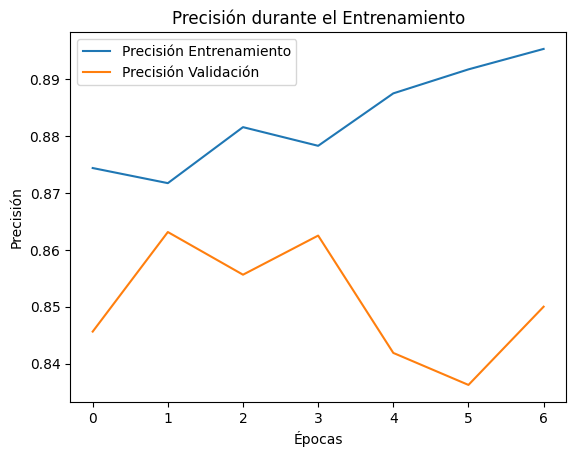

In [37]:
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento')
plt.legend()
plt.show()


En este gráfico, se observa la pérdida durante el entrenamiento y la validación. La pérdida del entrenamiento disminuye constantemente, lo que indica que el modelo está aprendiendo de los datos. Sin embargo, la pérdida de validación muestra fluctuaciones e incluso comienza a aumentar después de algunas épocas.

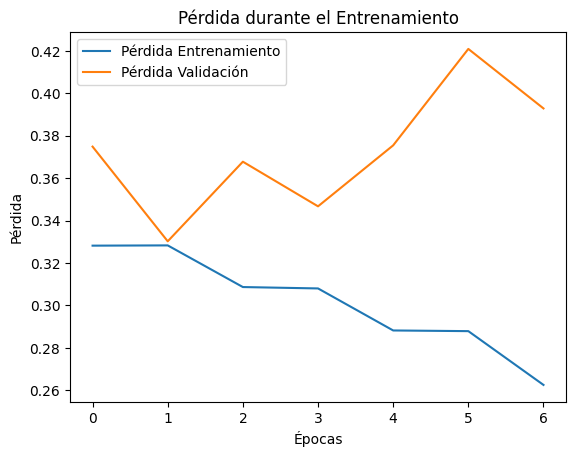

In [38]:
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento')
plt.legend()
plt.show()

En este gráfico, se observa la pérdida durante el entrenamiento y la validación. La pérdida del entrenamiento disminuye constantemente, lo que indica que el modelo está aprendiendo de los datos. Sin embargo, la pérdida de validación muestra fluctuaciones e incluso comienza a aumentar después de algunas épocas.


In [76]:
from tensorflow.keras.preprocessing import image

In [77]:
ruta_imagen_prueba = '/home/rou/Prueba/enojo.jpg'

In [78]:
def cargar_y_preprocesar_imagen(ruta_imagen, target_size=(224, 224)):
    img = image.load_img(ruta_imagen, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [79]:
def predecir_emocion(modelo, ruta_imagen, class_indices):
    img_array = cargar_y_preprocesar_imagen(ruta_imagen)
    prediccion = modelo.predict(img_array)
    clase_predicha = np.argmax(prediccion)
    clases = {v: k for k, v in class_indices.items()}
    nombre_clase = clases[clase_predicha]
    return nombre_clase, prediccion

In [80]:
nombre_clase, prediccion = predecir_emocion(model, ruta_imagen_prueba, train_generator.class_indices)

print(f"Emoción predicha: {nombre_clase}")
print(f"Probabilidades: {prediccion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Emoción predicha: neutral
Probabilidades: [[0.00212587 0.02797282 0.96834767 0.00155364]]


In [81]:
from tensorflow.keras.utils import load_img

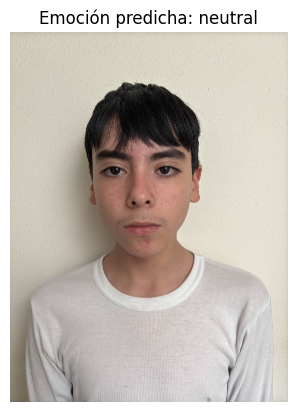

In [75]:
def mostrar_imagen_con_prediccion(ruta_imagen, nombre_clase):
    img = load_img(ruta_imagen)
    plt.imshow(img)
    plt.title(f"Emoción predicha: {nombre_clase}")
    plt.axis('off')
    plt.show()

mostrar_imagen_con_prediccion(ruta_imagen_prueba, nombre_clase)

Utilicé fotos de mi hermano para probar el modelo.
Aquí predijo la emoción de manera correcta.

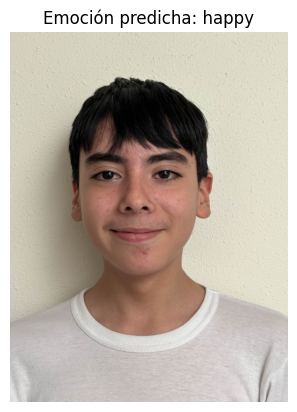

In [68]:
def mostrar_imagen_con_prediccion(ruta_imagen, nombre_clase):
    img = load_img(ruta_imagen)
    plt.imshow(img)
    plt.title(f"Emoción predicha: {nombre_clase}")
    plt.axis('off')
    plt.show()

mostrar_imagen_con_prediccion(ruta_imagen_prueba, nombre_clase)

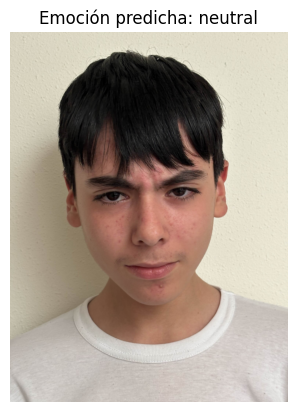

In [82]:
def mostrar_imagen_con_prediccion(ruta_imagen, nombre_clase):
    img = load_img(ruta_imagen)
    plt.imshow(img)
    plt.title(f"Emoción predicha: {nombre_clase}")
    plt.axis('off')
    plt.show()

mostrar_imagen_con_prediccion(ruta_imagen_prueba, nombre_clase)

El modelo predijo la emoción como neutral, aunque la intención era mostrar una **cara enojada**. Esto ocurrió porque las características visuales del enojo (como cejas fruncidas o labios tensos) no eran lo suficientemente marcadas, lo que llevó al modelo a clasificarla como neutral.

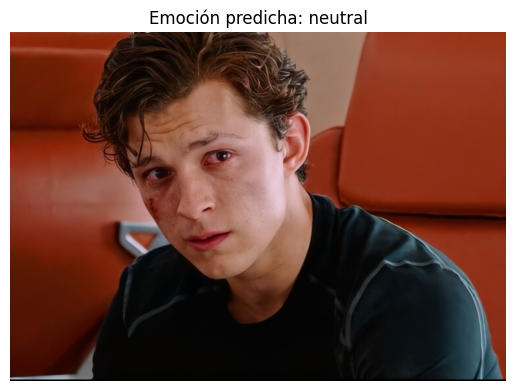

In [61]:
def mostrar_imagen_con_prediccion(ruta_imagen, nombre_clase):
    img = load_img(ruta_imagen)
    plt.imshow(img)
    plt.title(f"Emoción predicha: {nombre_clase}")
    plt.axis('off')
    plt.show()

mostrar_imagen_con_prediccion(ruta_imagen_prueba, nombre_clase)

El modelo predijo la emoción como neutral en lugar de triste porque los rasgos de tristeza en la imagen, como la mirada caída o los ojos enrojecidos, pueden ser sutiles y similares a una expresión neutral.

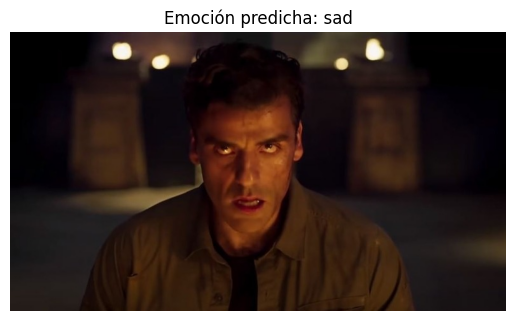

In [51]:
def mostrar_imagen_con_prediccion(ruta_imagen, nombre_clase):
    img = load_img(ruta_imagen)
    plt.imshow(img)
    plt.title(f"Emoción predicha: {nombre_clase}")
    plt.axis('off')
    plt.show()

mostrar_imagen_con_prediccion(ruta_imagen_prueba, nombre_clase)

El modelo predijo la emoción como sad (triste) en lugar de enojo, probablemente porque las características de la expresión, como el ceño fruncido y la intensidad de la mirada, pueden ser interpretadas como señales de tristeza en lugar de enojo. Esto puede sugerir que el modelo tiene dificultades para distinguir emociones similares, especialmente cuando comparten rasgos faciales comunes, como líneas en el rostro o tensión en los ojos.

## Conclusion

En este proyecto, logré construir y entrenar un modelo basado en VGG16 para clasificar emociones faciales en cuatro categorías principales: "Anger", "Happy", "Neutral" y "Sad". Aunque el modelo alcanzó una precisión aceptable en validación, noté desafíos importantes en la clasificación, especialmente entre emociones con características visuales similares, como "Anger" y "Sad".

El análisis de la matriz de confusión y las curvas de precisión reveló que, aunque el modelo captura patrones generales, todavía tiene margen de mejora para diferenciar ciertas emociones. Esto podría deberse a la naturaleza compleja del dataset o a limitaciones en la arquitectura utilizada.

En general, el modelo demuestra un buen punto de partida para tareas de reconocimiento emocional, pero para lograr mayor precisión, sería necesario explorar técnicas adicionales, como el uso de arquitecturas más avanzadas, mayor preprocesamiento de datos o aumentar la diversidad del dataset. Este proyecto me permitió entender los desafíos de trabajar con datos visuales complejos y aplicar técnicas de ajuste y evaluación en un modelo de deep learning.



## Oportunidades futuras

1. **Exploración de nuevas arquitecturas:** Probar otros modelos para mejorar la precisión y reducir el riesgo de sobreajuste (Como ResNet50 o Inception).
2. **Aumento de datos:** Incluir imágenes de diferentes fuentes y condiciones de iluminación para robustecer el modelo.
3. **Clasificación de Emociones Complejas:** Investigar la clasificación de emociones mixtas o de mayor complejidad (por ejemplo, sorpresa, disgusto o miedo) y no solo emociones básicas.
4. **Adaptación a Diferentes Culturas:** Investigar cómo la percepción de emociones varía entre culturas y ajustar el modelo para que sea más inclusivo y preciso en diferentes regiones.



## Bibliografía

1. **AffectNet Dataset**  
   Mollahosseini, A., Hasani, B., & Mahoor, M. H. (2017). AffectNet: A database for facial expression, valence, and arousal computing in the wild. *IEEE Transactions on Affective Computing, 10*(1), 18-31.
   [Disponible en: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data/data]

2. DataPeaker. (s.f.). Fine-tuning. , from https://datapeaker.com/wiki/fine-tuning/

3. Keras. (n.d.). EarlyStopping. Keras Documentation., from https://keras.io/api/callbacks/early_stopping/

